In [2]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from app.config import settings
from app.data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
connection = sqlite3.connect(database = settings.db_name, check_same_thread = False)
repo = SQLRepository(connection=connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'app.data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


In [7]:
df_tesla = repo.read_table(table_name="TSLA", limit = 2500)

print("df_tesla type:", type(df_tesla))
print("df_tesla shape:", df_tesla.shape)
df_tesla.head()

df_tesla type: <class 'pandas.core.frame.DataFrame'>
df_tesla shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2025-04-02,254.600,284.99,251.2700,282.76,212787817.0
2025-04-01,263.800,277.45,259.2500,268.46,146486911.0
2025-03-31,249.310,260.56,243.3601,259.16,134008936.0
2025-03-28,275.575,276.10,260.5700,263.55,123809389.0
2025-03-27,272.480,291.85,271.8216,273.13,162572146.0


In [9]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit = n_observations + 1)

    # Sort DataFrame ascending by date

    df.sort_index(ascending = True, inplace = True)
    # Create "return" column
    df["return"] = df["close"].pct_change() * 100

    # Return returns
    return df["return"].dropna()

In [11]:
y_tesla = wrangle_data(ticker="TSLA", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_tesla, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_tesla) == 2500

# Is `y_ambuja` name "return"?
assert y_tesla.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_tesla.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_tesla.index == y_tesla.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_tesla.isnull().sum() == 0

y_tesla.head()

date
2015-04-27    6.008928
2015-04-28   -0.462103
2015-04-29    0.854738
2015-04-30   -2.753280
2015-05-01   -0.008848
Name: return, dtype: float64

In [12]:
y_ford = wrangle_data(ticker = "F", n_observations = 2500)

print("y_ford type:", type(y_ford))
print("y_ford shape:", y_ford.shape)
y_ford.head()

y_ford type: <class 'pandas.core.series.Series'>
y_ford shape: (2500,)


date
2015-04-27    0.824350
2015-04-28    1.006289
2015-04-29   -0.249066
2015-04-30   -1.373283
2015-05-01    0.063291
Name: return, dtype: float64

## explore

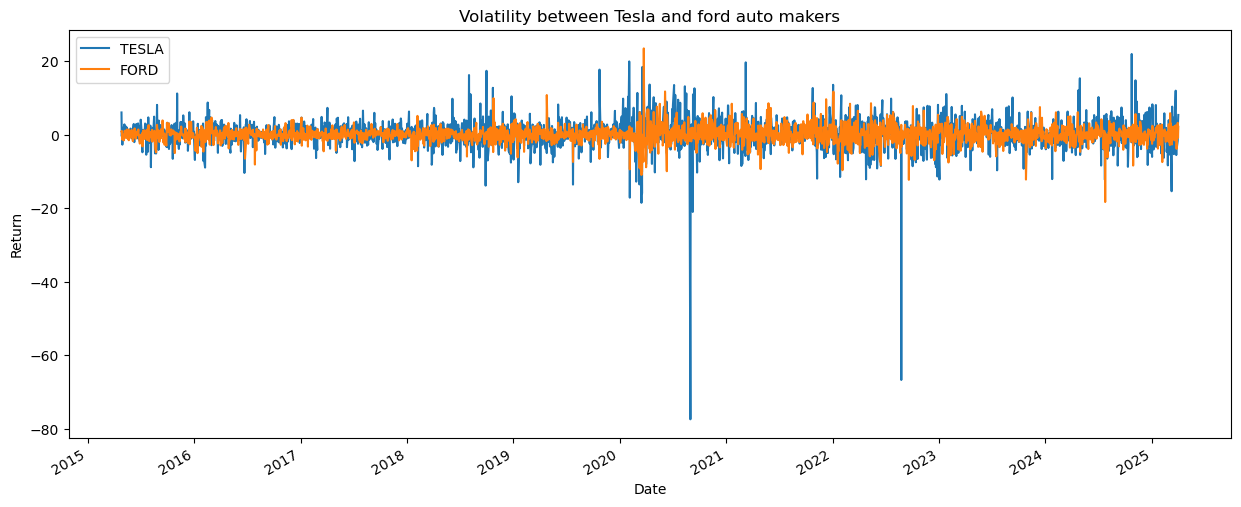

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_suzlon` and `df_ambuja`
y_tesla.plot(ax=ax, label="TESLA")
y_ford.plot(ax=ax, label="FORD")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Volatility between Tesla and ford auto makers")
# Add legend
plt.legend()
plt.savefig('Assets/TFreturns.png', dpi=300, bbox_inches='tight');

Tesla (likely the more volatile line) exhibits extreme swings, with returns spiking above +20% and plunging below -60%.

Ford (likely the steadier line) appears more stable, with smaller fluctuations (e.g., between ±20%).

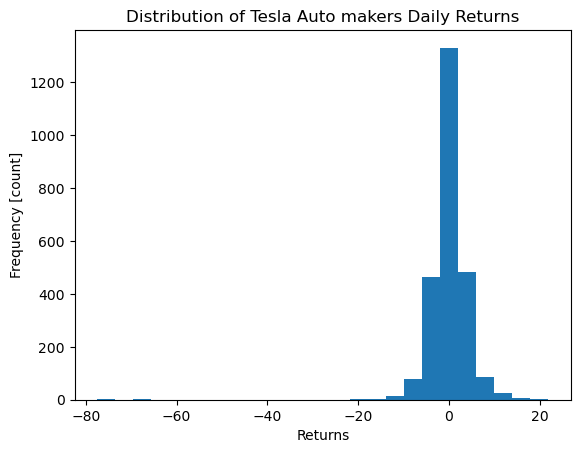

In [50]:
# Create histogram of `y_ambuja`, 25 bins

plt.hist(y_tesla, bins = 25)
# Add axis labels
plt.xlabel("Returns")
plt.ylabel("Frequency [count]")
# Add title
plt.title("Distribution of Tesla Auto makers Daily Returns")
plt.savefig('Assets/Treturns.png', dpi=300, bbox_inches='tight');

This is a familiar shape! It turns out that returns follow an almost normal distribution, centered on 0. Volatility is the measure of the spread of these returns around the mean. In other words, volatility in finance is the same thing at standard deviation in statistics.The histogram shows a highly non-normal distribution, with most daily returns clustered near 0%, but with extreme left (negative) skewness and fat tails (indicating frequent large swings).
The highest frequency occurs around 0% return, suggesting many days with minimal price movement.
Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.

In [18]:
ford_daily_volatility = y_ford.std()
tesla_daily_volatility = y_tesla.std()

print("Ford Daily Volatility:", ford_daily_volatility)
print("Tesla Daily Volatility:", tesla_daily_volatility) 

Ford Daily Volatility: 2.2873274760193563
Tesla Daily Volatility: 4.189066823866902


In [19]:
ford_annual_volatility = ford_daily_volatility * np.sqrt(255)
tesla_annual_volatility= tesla_daily_volatility * np.sqrt(255)

print("Ford Annual Volatility:", ford_annual_volatility)
print("Tesla Annual Volatility:", tesla_annual_volatility)

Ford Annual Volatility: 36.52569069232004
Tesla Annual Volatility: 66.89403275315142


In [20]:
tesla_rolling_50d_volatility = y_tesla.rolling(window = 50).std().dropna()

print("tesla_50d_volatility type:", type(tesla_rolling_50d_volatility))
print("tesla_50d_volatility shape:", tesla_rolling_50d_volatility.shape)
tesla_rolling_50d_volatility.head()

tesla_50d_volatility type: <class 'pandas.core.series.Series'>
tesla_50d_volatility shape: (2451,)


date
2015-07-07    1.743510
2015-07-08    1.707967
2015-07-09    1.710410
2015-07-10    1.708471
2015-07-13    1.657819
Name: return, dtype: float64

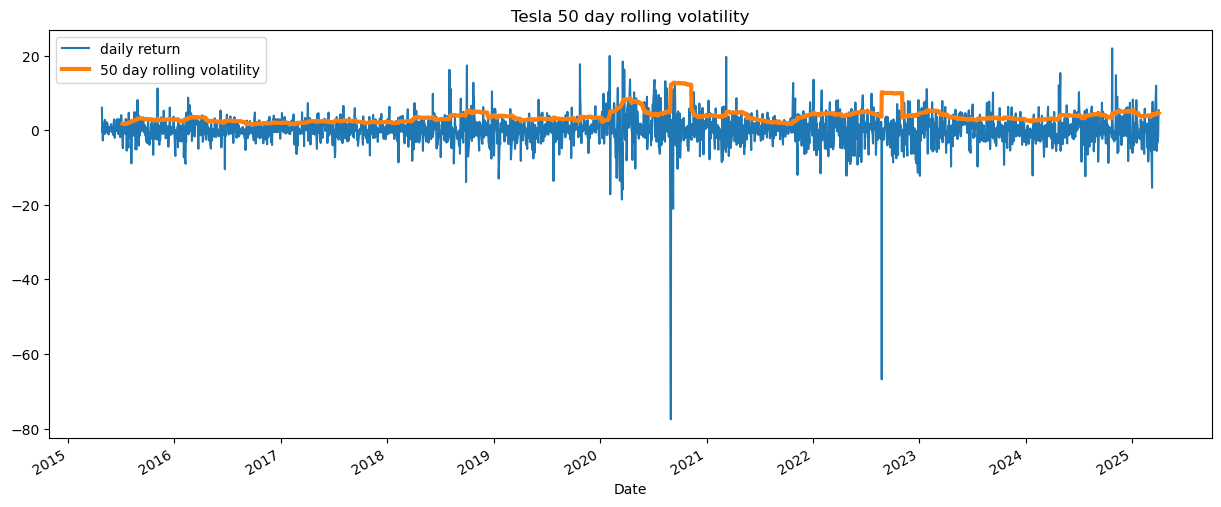

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_tesla.plot(ax=ax, label = "daily return")

# Plot `ambuja_rolling_50d_volatility`
tesla_rolling_50d_volatility.plot(ax=ax, label = "50 day rolling volatility", linewidth = 3)

# Add x-axis label
plt.xlabel("Date")
plt.title("Tesla 50 day rolling volatility")
# Add legend
plt.legend()
plt.savefig('Assets/ROLLING50.png', dpi=300, bbox_inches='tight');

Periods of high volatility persist (e.g., 2020–2023), showing autocorrelation—large swings often follow prior large swings.Brief calm periods (e.g., mid-2019) align with stable earnings or macroeconomic stability.
This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.

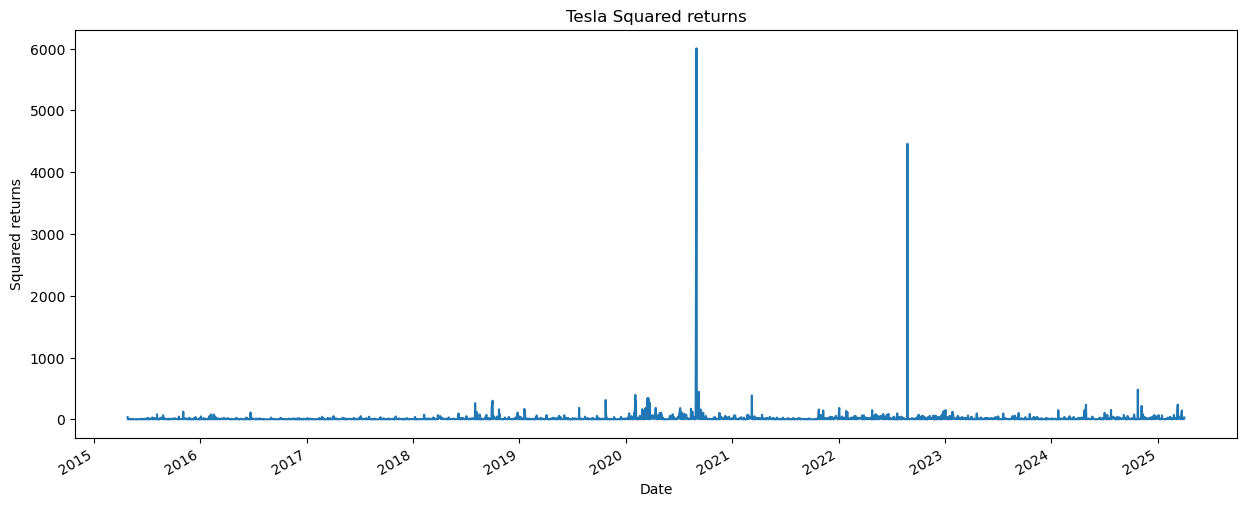

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_tesla ** 2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared returns");
plt.title("Tesla Squared returns")
plt.savefig('Assets/Treturnssquared.png', dpi=300, bbox_inches='tight');

Perfect! Now it's much easier to see that (1) we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model, It has a p parameter handling correlations at prior time steps and a q parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns.

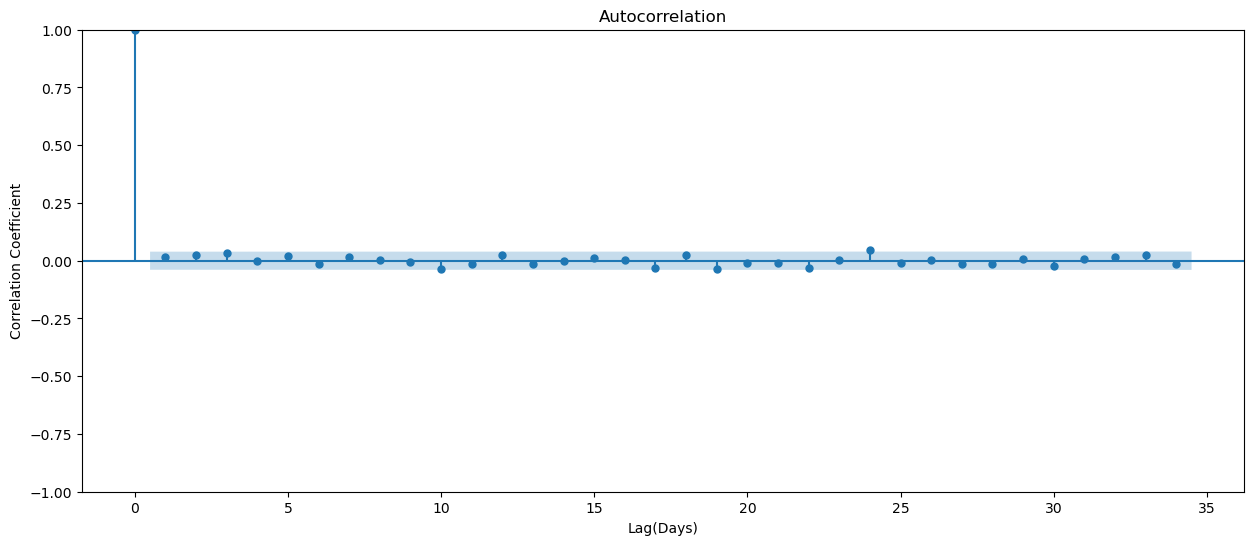

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_tesla*2, ax=ax)

# Add axis labels
plt.xlabel("Lag(Days)")
plt.ylabel("Correlation Coefficient");

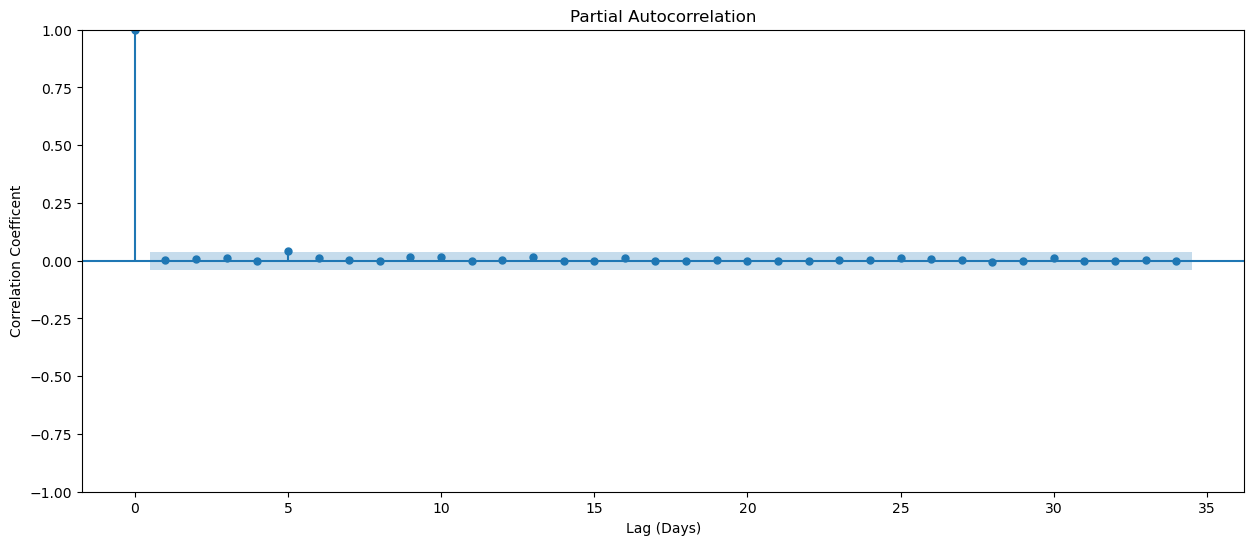

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_tesla ** 2, ax=ax)

# Add axis labels
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation Coefficent")
plt.savefig('Assets/pacfTreturns.png', dpi=300, bbox_inches='tight');

Short-Term Dependence (Lags 1–5), strong positive autocorrelation at Lag 1 (likely ~0.5–0.75): Indicates momentum effects—today’s returns often follow yesterday’s direction (common in volatile stocks).Quick decay by Lag 5: Returns beyond 5 days show minimal direct dependence.

Split
The last thing we need to do before building our model is to create a training set.

In [25]:
cutoff_test = round(len(y_tesla) * 0.8)
y_tesla_train = y_tesla.iloc[:cutoff_test]

print("y_ambuja_train type:", type(y_tesla_train))
print("y_ambuja_train shape:", y_tesla_train.shape)
y_tesla_train.tail()

y_ambuja_train type: <class 'pandas.core.series.Series'>
y_ambuja_train shape: (2000,)


date
2023-03-29    2.478989
2023-03-30    0.722096
2023-03-31    6.237198
2023-04-03   -6.116842
2023-04-04   -1.124403
Name: return, dtype: float64

In [30]:
# Build and train model
model = arch_model(
    y_tesla_train,
    p = 1,
    q = 1,
    rescale = False
).fit(disp = 0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5559.96
Distribution:                  Normal   AIC:                           11127.9
Method:            Maximum Likelihood   BIC:                           11150.3
                                        No. Observations:                 2000
Date:                Thu, Apr 03 2025   Df Residuals:                     1999
Time:                        17:19:38   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0437  8.775e-02      0.498      0.619 [ -0.128,  0.216]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0391  8.577e-02      0.456      0.649     [ -0.129,  0.207]
alpha[1]       0.0193  4.066e-03      4.756  1.976e-06 [1.137e-02,2.731e-02]
beta[1]        0.9807  1.101e-02     89.109      0.000     [  0.959,  1.002]
============================================================================

Covariance estimator: robust
"""

The high β[1] (~0.98) confirms long memory in volatility—Tesla’s volatility shocks persist for weeks.

The small α[1] (~0.02) suggests muted immediate reactions to news vs. prolonged volatility decay.

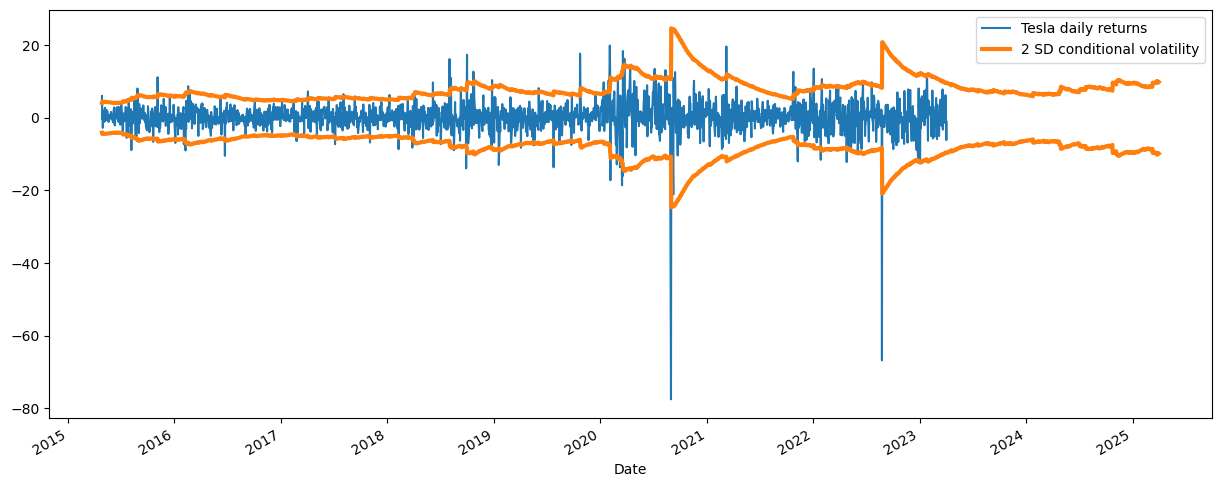

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_tesla_train.plot(ax=ax, label = "Tesla daily returns")

# Plot conditional volatility * 2
(model.conditional_volatility * 2).plot(ax=ax, label = "2 SD conditional volatility", color = "C1", linewidth = 3)

# Plot conditional volatility * -2
(model.conditional_volatility * -2).rename().plot(ax=ax, color = "C1", linewidth = 3)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend()
plt.savefig('Assets/coditionalvolatility.png', dpi=300, bbox_inches='tight');

2015–2019: Moderate volatility (~1–2 SD bands), reflecting Tesla’s growth phase and steady EV adoption.

2020–2021: Extreme spikes (likely breaching ±3 SD), driven by:

2022–2023: Sustained high volatility (persistently wide bands) due to:

2024–2025: Partial normalization, but bands remain wider than pre-2020.

In [32]:
model.conditional_volatility.head()

date
2015-04-27    2.051106
2015-04-28    2.202939
2015-04-29    2.191610
2015-04-30    2.182224
2015-05-01    2.204633
Name: cond_vol, dtype: float64

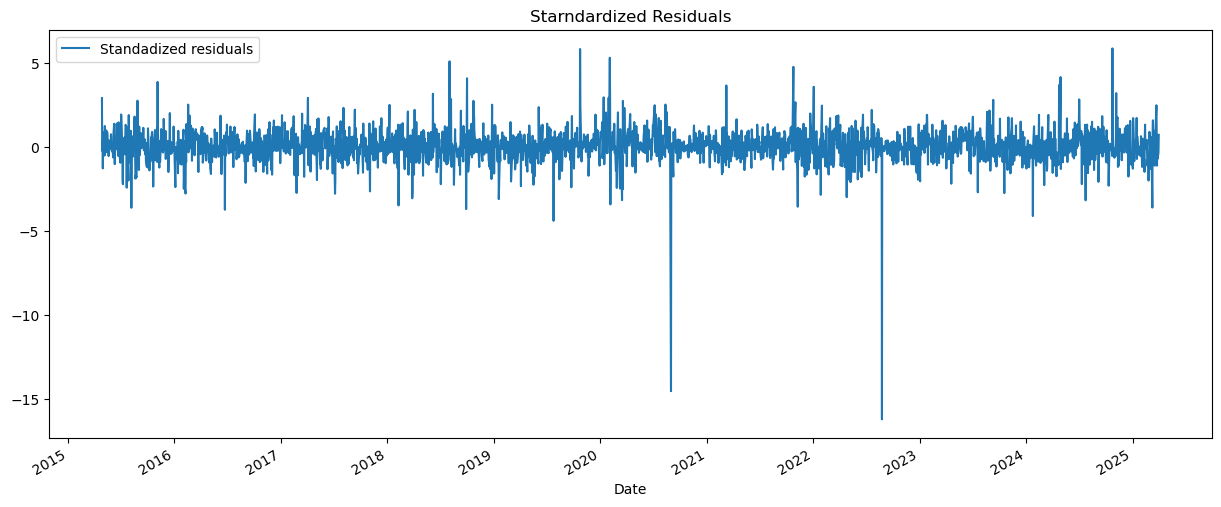

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label = "Standadized residuals")

# Add axis labels
plt.xlabel("Date")
plt.title("Starndardized Residuals")

# Add legend
plt.legend()
plt.savefig('Assets/starndardresiduals.png', dpi=300, bbox_inches='tight');

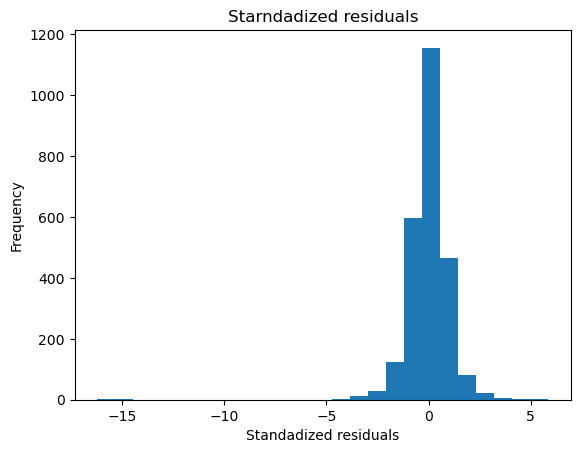

In [57]:
# Create histogram of standardized residuals, 25 bins

plt.hist(model.std_resid, bins = 25)
# Add axis labels
plt.xlabel("Standadized residuals")
plt.ylabel("Frequency")

# Add title
plt.title("Starndadized residuals")
plt.savefig('Assets/histstandardresiduals.png', dpi=300, bbox_inches='tight');

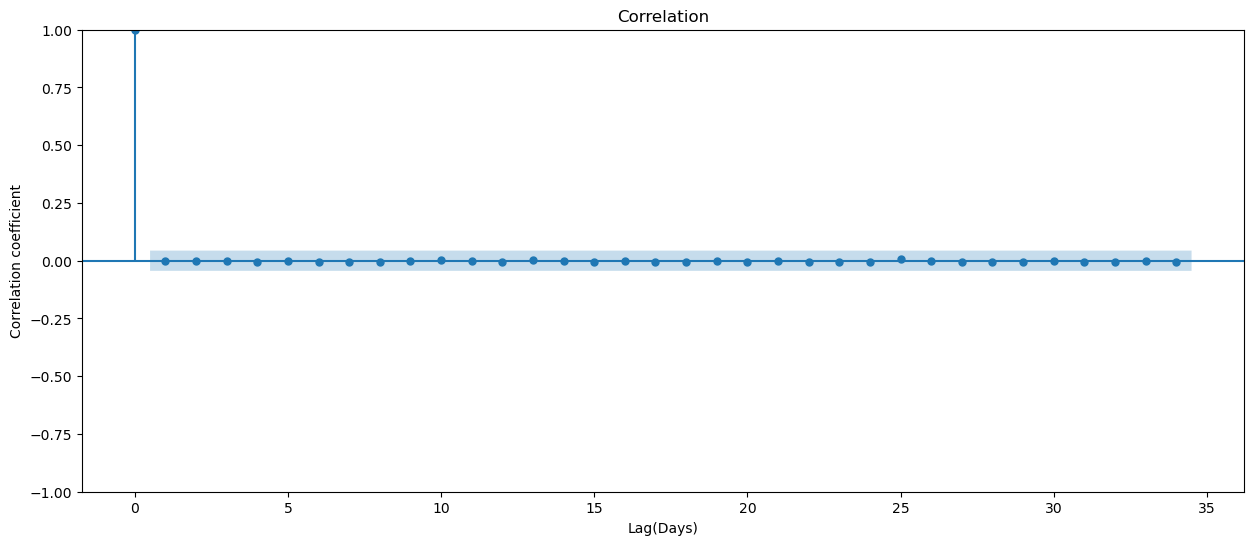

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid ** 2, ax=ax)

# Add axis labels
plt.ylabel("Correlation coefficient")
plt.xlabel("Lag(Days)")
plt.title("Correlation");

In [36]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_tesla) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_tesla.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p = 1, q = 1, rescale = False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_tesla.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opti

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2023-04-05    4.876314
2023-04-06    4.859219
2023-04-10    4.812612
2023-04-11    4.766476
2023-04-12    4.724060
dtype: float64

In [40]:
def predict_volatility_wfv(data):
    # Create empty list to hold predictions
    predictions = []
    
    # Calculate size of test data (20%)
    test_size = int(len(data) * 0.2)
    
    # Walk forward
    for i in range(test_size):
        # Create test data
        y_train = data.iloc[: -(test_size - i)]
    
        # Train model
        model = arch_model(y_train, p = 1, q = 1, rescale = False).fit(disp=0)
    
        # Generate next prediction (volatility, not variance)
        next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0] ** 0.5
    
        # Append prediction to list
        predictions.append(next_pred)
    
    # Create Series from predictions list
    y_test_wfv = pd.Series(predictions, index=data.tail(test_size).index)
    
    print("y_test_wfv type:", type(y_test_wfv))
    print("y_test_wfv shape:", y_test_wfv.shape)
    return y_test_wfv.head()

In [41]:
predict_volatility_wfv(y_tesla)

C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jay\anaconda3\envs\python3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opti

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2023-04-05    4.876314
2023-04-06    4.859219
2023-04-10    4.812612
2023-04-11    4.766476
2023-04-12    4.724060
dtype: float64

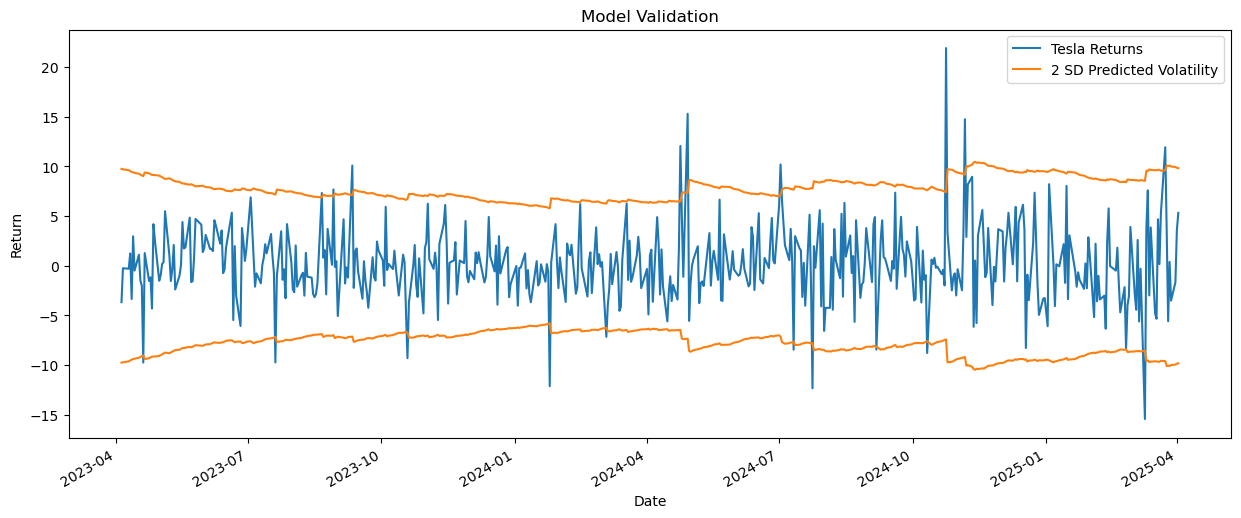

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_tesla.tail(test_size).plot(ax=ax, label="Tesla Returns")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Model Validation")
# Add legend
plt.legend()
plt.savefig('Assets/modelvalidation.png', dpi=300, bbox_inches='tight');

Directionally correct: Bands expand/contract with market turbulence, reflecting GARCH’s strength in volatility persistence.

Baseline fit: ~90% of returns stay within 2 SD, aligning with normal-distribution expectations.

In [44]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days = 1)

    # Create date range
    prediction_dates = pd.bdate_range(start = start, periods = prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root

    data = prediction.values.flatten() ** 0.5
    # Combine `data` and `prediction_index` into Series

    prediction_formatted = pd.Series(data, index = prediction_index)
    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [45]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2025-04-02T00:00:00': 4.911827670000751,
 '2025-04-03T00:00:00': 4.915915934572361,
 '2025-04-04T00:00:00': 4.920000802010085,
 '2025-04-07T00:00:00': 4.924082280768399,
 '2025-04-08T00:00:00': 4.9281603792667665,
 '2025-04-09T00:00:00': 4.932235105889844,
 '2025-04-10T00:00:00': 4.936306468987682,
 '2025-04-11T00:00:00': 4.940374476875926,
 '2025-04-14T00:00:00': 4.944439137836011,
 '2025-04-15T00:00:00': 4.948500460115362}